In [1]:
import scipy.special
import numpy as np
import itertools
from skimage.segmentation import slic

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import argparse
import time
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

from PIL import Image

%matplotlib inline

In [2]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--gamma', type=float, default=0.0001, metavar='GAMMA',
                    help='learning rate (default: 0.0001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')

args, _ = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

tr_split_len = 6000
te_split_len = 1000
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
tr = datasets.MNIST('../data', train=True, download=True, transform=trans)
te = datasets.MNIST('../data', train=False, transform=trans)

part_tr = torch.utils.data.random_split(tr, [tr_split_len, len(tr)-tr_split_len])[0]
part_te = torch.utils.data.random_split(te, [te_split_len, len(te)-te_split_len])[0]



In [3]:
def test_WLR(model, test_loader):
    correct = 0
    total = 0
    for i, (data, labels) in enumerate(test_loader):
        data = data.view(data.shape[0], -1)
        X, y = data.to(device), labels.to(device)

        outputs = torch.softmax(model(X), 1)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.to(device)

        total += labels.size(0)
        correct += (predicted == y).sum()

    accuracy = 100 * correct.item() / total
    return accuracy

In [4]:
class WeightedLogisticRegression(torch.nn.Module):
    def __init__(self, M):
        super(WeightedLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(M, 10)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


def train_WLR(model, X_train, y_train, train_weight, device, args, optimizer):
    
    model.train()
    criterion = nn.CrossEntropyLoss()
    for i in range(args.epochs):
        tw = 0
        loss = 0
        for j in range(len(X_train)):
            data, target = X_train[j], y_train[j]
            data = data.view(1, -1)
            X, y = data.to(device), target.to(device)

            optimizer.zero_grad()

            y_pred = model(X)
            t_weight = train_weight[tw]
            tw += 1
            loss += t_weight * criterion(y_pred, y)
    
        l2reg = torch.trace(torch.mm(model.linear.weight, model.linear.weight.T)) + torch.sum(model.linear.bias ** 2)
        loss += 0.5 * args.gamma * l2reg
        loss.backward()

        optimizer.step()
            
#     print("train accuracy = ", test(model, train_loader))
#     print("test accuracy = ", test_WLR(model, test_loader))
    return model.linear.weight, model.linear.bias

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [7]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310445
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.222542
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.699302
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.997129
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.929851

Test set: Average loss: 0.0049, Accuracy: 8940/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.844786
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.512887
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.474189
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.553361
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.392153

Test set: Average loss: 0.0025, Accuracy: 9372/10000 (94%)



In [8]:
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


In [9]:
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def shapley_kernel(M,s):
    if s == 0 or s == M:
        return 100000
    return (M-1)/(scipy.special.binom(M,s)*s*(M-s))

def func(X, model):
    predict = model(torch.tensor(X)).max(1, keepdim=True)[1]
    return predict

def mask_image(img, img_slic, s):
    out = np.zeros(img_slic.shape)
    for i in range(img_slic.shape[0]):
        for j in range(img_slic.shape[1]):
            if img_slic[i][j] in s:
                out[i][j] = img[i][j]      
    return torch.tensor(out)

In [10]:
def kernel_shap(model, x, x_slic, reference, M):
    weights = np.zeros(2**M)
    V = torch.zeros((2**M, 1, x_slic.shape[0], x_slic.shape[1]))
    X = torch.zeros((2**M, M))
    for i,s in enumerate(powerset(range(M))):
        s = list(s)
        V[i] = mask_image(x, x_slic, s).view(1, 28, 28)
        X[i, s] = 1
        weights[i] = shapley_kernel(M,len(s))
    y = func(V, model)
    WLR_model = WeightedLogisticRegression(M).to(device)
    args.epochs = 20
    args.lr = 0.01
    optimizer = torch.optim.SGD(WLR_model.parameters(), lr=args.lr)
    w, b= train_WLR(WLR_model, X, y, weights, device, args, optimizer)
    return w, b

In [60]:
#choosing a sample to explain
for test_images, test_labels in test_loader: 
    sample_image = test_images[0]  
    sample_label = test_labels[0]
    break

In [61]:
M = 14
mask = np.ones((28, 28))
img = sample_image.reshape((28, 28))
img_slic = slic(img, n_segments=M, mask=mask, start_label=0)
img_slic_tensor = torch.tensor(slic(img, n_segments=M, mask=mask, start_label=0))

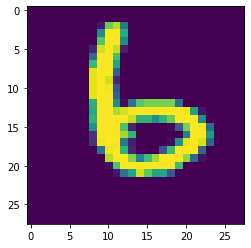

In [62]:
plt.imshow(img)

/home/motahareh/environment_directory/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  


Text(0.5, 1.0, 'maskSLIC')

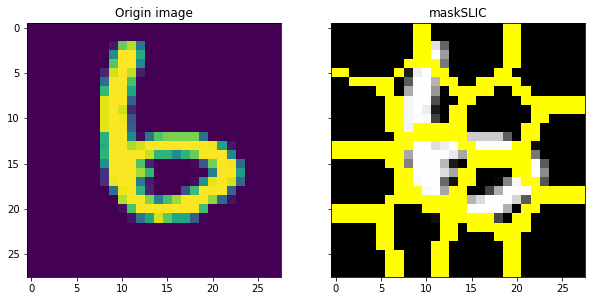

In [63]:
fig, ax_arr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title("Origin image")

ax2.imshow(segmentation.mark_boundaries(img, img_slic))
ax2.contour(mask, colors='red', linewidths=1)
ax2.set_title("maskSLIC")

In [64]:
start_time = time.time()
shap_values, b = kernel_shap(model, img, img_slic_tensor, mask, M)
end_time = time.time()
print("finished in ", end_time - start_time)

/home/motahareh/environment_directory/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


finished in  502.4418556690216


10 segments: 32sec =5 32
11 segments: 63sec =6 64
12 segments: 139sec=7 128
13 segments: 297sec=8 256
14 segments: 679sec=9 512

In [65]:
def fill_segments(img_slic, w):
    out = np.zeros((img_slic.shape[0], img_slic.shape[1]))
    for i in range(img_slic.shape[0]):
        for j in range(img_slic.shape[1]):
            out[i][j] = w[img_slic[i][j]]
    return out

In [66]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

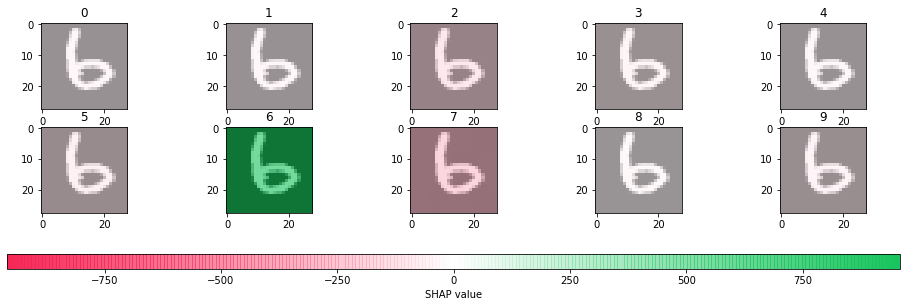

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,5))
max_val = np.max(np.abs(shap_values.detach().numpy()))
trans = transforms.ToPILImage()
for i in range(2):
    for j in range(5):
        axes[i][j].set_title(5 * i + j)
        im = axes[i][j].imshow(fill_segments(img_slic, shap_values[5 * i + j]), cmap=cm, vmin=-max_val, vmax=max_val)
        axes[i][j].imshow(trans(img).convert('LA'), alpha=0.4)  
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)


In [84]:
c = 6
max_val = max(shap_values[c])
min_val = min(shap_values[c])

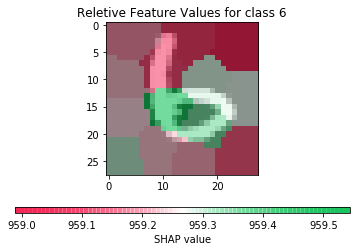

In [85]:
imm = plt.imshow(fill_segments(img_slic, shap_values[c]), cmap=cm, vmin=min_val, vmax=max_val)
plt.imshow(trans(img).convert('LA'), alpha=0.4) 
plt.title("Reletive Feature Values for class " + str(c))
cb = plt.colorbar(imm, label="SHAP value", orientation="horizontal", aspect=60)
